# Cumulative Token, Type, and TTR analysis
One of the supposed features of feminine language is a more complex vocabulary. Is this generally true? Is it true for specific production companies?


In [1]:
import pandas as pd

In [2]:
all_movies_df = pd.read_pickle(r"C:\Users\cassi\Desktop\Data_Science\Animated-Movie-Gendered-Dialogue\private\char_toks.pkl")

In [3]:
all_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 11 columns):
Disney_Period       632 non-null object
Gender              632 non-null object
Movie               632 non-null object
Role                632 non-null object
Speaker             632 non-null object
Speaker_Status      632 non-null object
Total_Tok_Count     632 non-null float64
Total_Toks          632 non-null object
Total_Type_Count    632 non-null float64
Total_Types         632 non-null object
Year                632 non-null object
dtypes: float64(2), object(9)
memory usage: 32.1+ KB


In [4]:
all_movies_df.groupby('Gender')['Total_Tok_Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
f,139.0,347.848921,554.563700,2.0,10.5,63.0,446.5,2540.0
m,354.0,314.223164,631.755182,2.0,10.0,45.0,269.5,3941.0
n,139.0,20.949640,40.650387,1.0,6.0,10.0,23.0,412.0


## Adding TTR
I'm going to add a TTR column and Guiraud's modified TTR.

In [5]:
import math

In [6]:
all_movies_df['TTR'] = all_movies_df.Total_Type_Count / all_movies_df.Total_Tok_Count
all_movies_df['G_TTR'] = all_movies_df.Total_Type_Count / (all_movies_df.Total_Tok_Count.map(math.sqrt))

In [7]:
all_movies_df.head()

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR
0,EARLY,f,Snow White,ANT,queen,NON-P,940.0,"[slave, in, the, magic, mirror, come, from, th...",314.0,"{fall, to, look, wo, kiss, 'd, queenly, so, so...",1937,0.334043,10.241551
1,EARLY,m,Snow White,ANT,mirror,NON-P,81.0,"[what, wouldst, thou, know, ,, my, queen, ?, f...",57.0,"{you, more, your, than, her, grace, not, lovel...",1937,0.703704,6.333333
2,EARLY,m,Snow White,PRO,prince,PRINCE,5.0,"[today, hello, ., one, song]",5.0,"{hello, song, one, today, .}",1937,1.000000,2.236068
3,EARLY,f,Snow White,PRO,snow white,PRINCESS,1231.0,"[oh, !, oh, ., hello, there, ., what, 's, the,...",311.0,"{mama, to, tidy, wo, look, 'd, eat, so, than, ...",1937,0.252640,8.864033
4,EARLY,m,Snow White,ANT,guard,NON-P,95.0,"[yes, ,, your, majesty, ., but, ,, your, majes...",43.0,"{you, come, your, back, never, little, run, of...",1937,0.452632,4.411707


In [8]:
all_movies_df.describe()

,Total_Tok_Count,Total_Type_Count,TTR,G_TTR
count,632.000000,632.000000,632.000000,632.000000
mean,257.117089,85.189873,0.693138,4.967259
std,553.919315,134.593696,0.257380,2.995887
min,1.000000,1.000000,0.166667,0.632456
25%,8.000000,7.000000,0.481947,2.468528
50%,27.500000,21.000000,0.700877,4.024922
75%,174.500000,95.250000,1.000000,7.229228
max,3941.000000,886.000000,1.000000,14.136698


In [9]:
from matplotlib import pyplot as plt

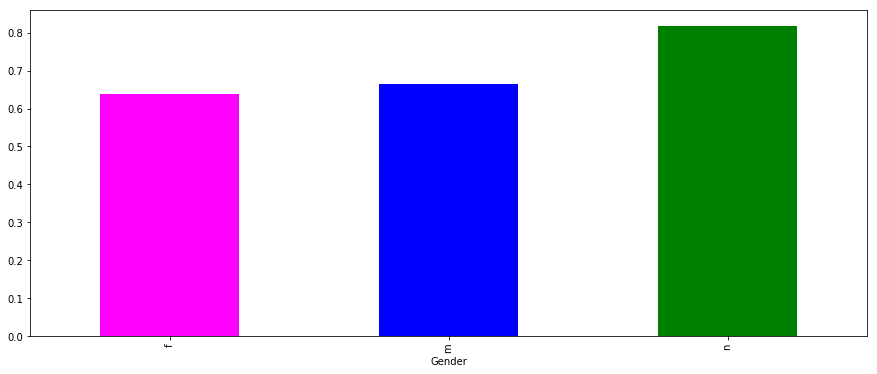

In [10]:
ttr_by_gender = all_movies_df.groupby(['Gender'])['TTR'].describe()['mean']
ttr_by_gender.plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

If we view TTR as a measure of vocabulary complexity, it looks like overall men have a slightly higher vocabulary complexity.

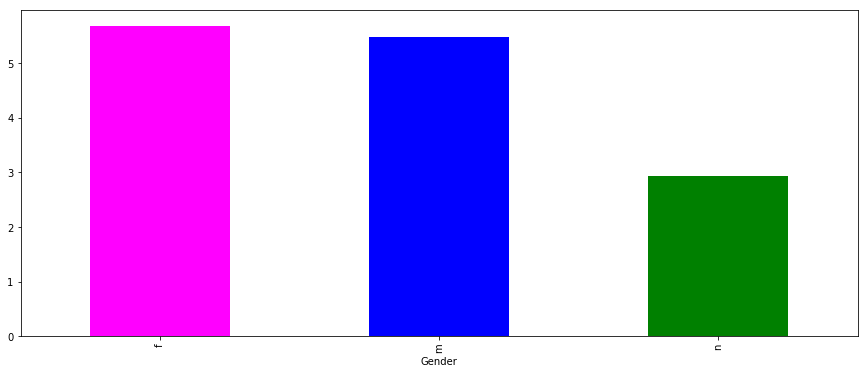

In [11]:
gttr_by_gender = all_movies_df.groupby(['Gender'])['G_TTR'].describe()['mean']
gttr_by_gender.plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

I'm not sure what a higher/lower GTTR means yet..I'll have to look more into it. 

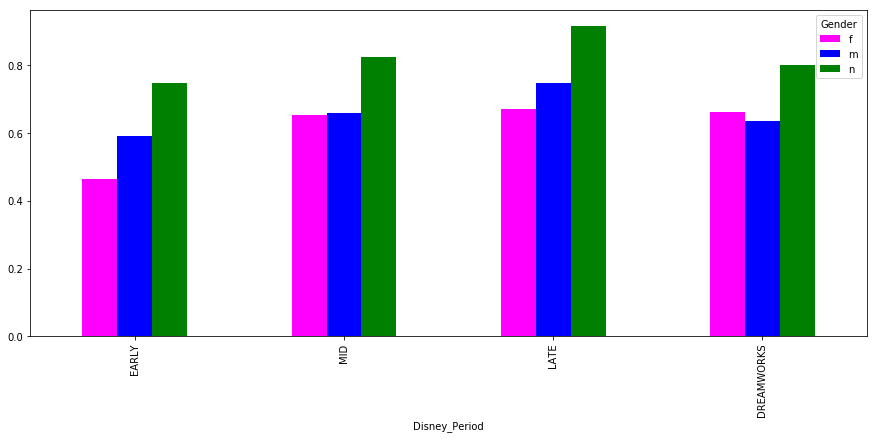

In [12]:
ttr_by_company_gender = all_movies_df.groupby(['Disney_Period', 'Gender'], sort=False)['TTR'].describe()['mean']
ttr_by_company_gender.unstack().plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

Hmmm. So, overall Female speakers have a higher TTR in Dreamworks movies, but in every Disney era, female speakers have a lower TTR. I would've thought that since Disney movies feature female protagonists, they would have higher TTRs. Maybe this is influenced by the length of their lines...If Dreamworks female characters aren't protagonists, their lines may not be as long, which would influence TTR?

Let's zoom into movies...

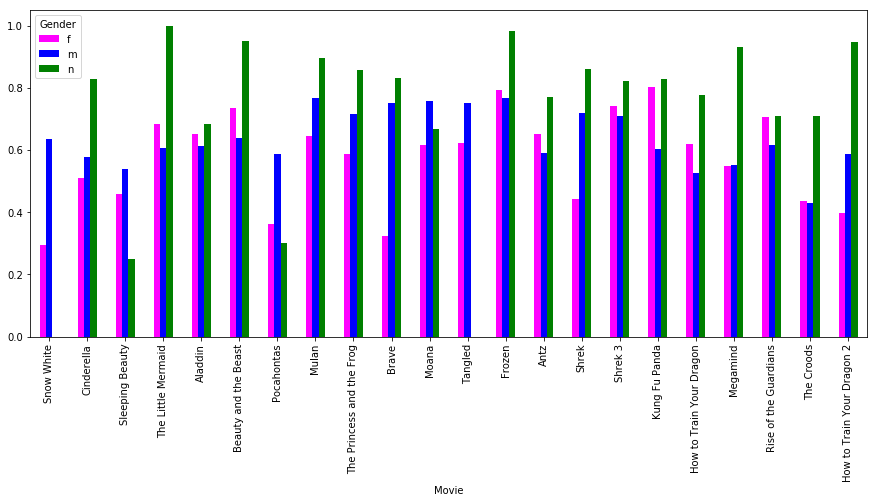

In [13]:
ttr_by_movie_gender = all_movies_df.groupby(['Movie', 'Gender'], sort=False)['TTR'].describe()['mean']
ttr_by_movie_gender.unstack().plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

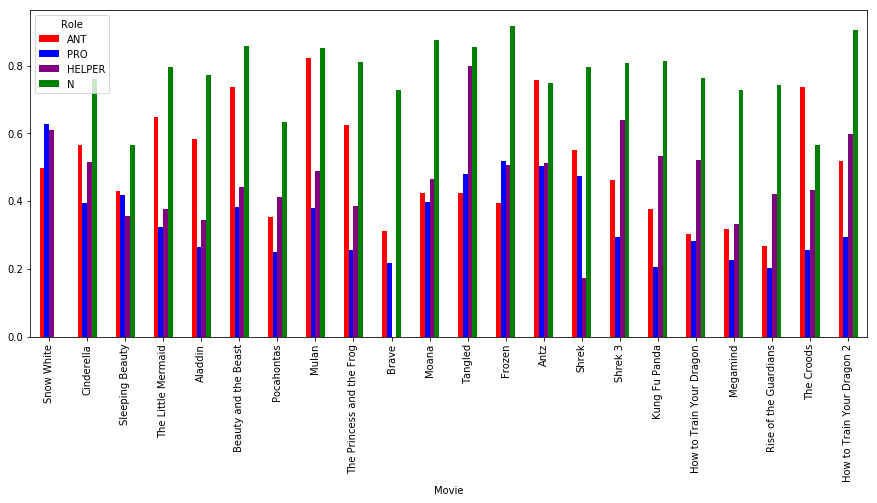

In [14]:
#looking at role...
ttr_by_movie_gender = all_movies_df.groupby(['Movie', 'Role'], sort=False)['TTR'].describe()['mean']
ttr_by_movie_gender.unstack().plot.bar(color = ['red', 'blue', 'purple', 'green'], figsize = (15,6))

Here, we find that overall, antagonists have a higher TTR. Could this be because they have a more refined vocabulary than the protagonists? Or are their lines simply shorter, creating a higher TTR? The same may be said for helpers...

## K-Bands
Another way to analyze vocabulary complexity is k-bands. I'll apply the following k-band code to each character's list of tokens to determine their average k-band. A higher k-band indicates a higher level of vocabulary complexity

In [15]:
import numpy as np

In [16]:

# thanks Na-Rae for this code!

def get_avg_google_kband(toks):
    """
    Computes the average K-band value from a list of tokens. 
    Limited to 20 K-bands: all words outside top 20,000 are excluded. 
    """
    kbands = []
    for t in toks:
        if t.lower() in google_1gram_rank: 
           grank = google_1gram_rank[t.lower()]
           if grank <= 50000:  # limiting to 50k 
               kband = math.floor(grank/1000)+1
               kbands.append(kband)
               #print(t, grank, kband)
    return np.mean(kbands)

In [17]:
# thanks Na-Rae for this code!

# reading file and setting up
# credit of the Google 1T English unigram frequency list goes to Peter Norbig's site: http://norvig.com/ngrams/
# these files can be used under the MIT license
google_1gram_lines = open('..\private\count_1w.txt').readlines()
google_1gram_tup = [tuple(line.split()) for line in google_1gram_lines]
google_1gram_rank = {word:index+1 for (index,(word, count)) in enumerate(google_1gram_tup)}

In [18]:
all_movies_df['AVG_K_BAND'] = all_movies_df['Total_Toks'].map(get_avg_google_kband)

c:\users\cassi\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\cassi\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
all_movies_df.head()

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
0,EARLY,f,Snow White,ANT,queen,NON-P,940.0,"[slave, in, the, magic, mirror, come, from, th...",314.0,"{fall, to, look, wo, kiss, 'd, queenly, so, so...",1937,0.334043,10.241551,3.660000
1,EARLY,m,Snow White,ANT,mirror,NON-P,81.0,"[what, wouldst, thou, know, ,, my, queen, ?, f...",57.0,"{you, more, your, than, her, grace, not, lovel...",1937,0.703704,6.333333,3.428571
2,EARLY,m,Snow White,PRO,prince,PRINCE,5.0,"[today, hello, ., one, song]",5.0,"{hello, song, one, today, .}",1937,1.000000,2.236068,1.750000
3,EARLY,f,Snow White,PRO,snow white,PRINCESS,1231.0,"[oh, !, oh, ., hello, there, ., what, 's, the,...",311.0,"{mama, to, tidy, wo, look, 'd, eat, so, than, ...",1937,0.252640,8.864033,3.270520
4,EARLY,m,Snow White,ANT,guard,NON-P,95.0,"[yes, ,, your, majesty, ., but, ,, your, majes...",43.0,"{you, come, your, back, never, little, run, of...",1937,0.452632,4.411707,3.610169


In [20]:
all_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 14 columns):
Disney_Period       632 non-null object
Gender              632 non-null object
Movie               632 non-null object
Role                632 non-null object
Speaker             632 non-null object
Speaker_Status      632 non-null object
Total_Tok_Count     632 non-null float64
Total_Toks          632 non-null object
Total_Type_Count    632 non-null float64
Total_Types         632 non-null object
Year                632 non-null object
TTR                 632 non-null float64
G_TTR               632 non-null float64
AVG_K_BAND          613 non-null float64
dtypes: float64(5), object(9)
memory usage: 46.9+ KB


In [21]:
all_movies_df[all_movies_df.AVG_K_BAND.isnull()]

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
9,EARLY,m,Snow White,HELPER,dopey,NON-P,2.0,"[shh, !]",2.0,"{shh, !}",1937,1.000000,1.414214,NaN
65,MID,n,The Little Mermaid,N,ariel and flounder,NON-P,2.0,"[oohhh, .]",2.0,"{., oohhh}",1989,1.000000,1.414214,NaN
106,MID,n,Aladdin,N,flamingo,NON-P,2.0,"[d'uh, !]",2.0,"{!, d'uh}",1992,1.000000,1.414214,NaN
175,MID,m,Mulan,HELPER,crickee,NON-P,10.0,"[chirp, ., chirp, ., chirp, ., chirp, ., chirp...",2.0,"{., chirp}",1998,0.200000,0.632456,NaN
192,MID,m,Mulan,N,guard #2,NON-P,2.0,"[concubines, .]",2.0,"{concubines, .}",1998,1.000000,1.414214,NaN
217,LATE,f,The Princess and the Frog,N,stella,NON-P,2.0,"[tiana, ?]",2.0,"{tiana, ?}",2009,1.000000,1.414214,NaN
263,LATE,f,Moana,N,female villager,NON-P,2.0,"[moana, !]",2.0,"{moana, !}",2016,1.000000,1.414214,NaN
315,LATE,n,Frozen,N,family,NON-P,2.0,"[hoo-hoo, !]",2.0,"{hoo-hoo, !}",2013,1.000000,1.414214,NaN
430,DREAMWORKS,n,Shrek,N,congregation,NON-P,2.0,"[aawww, !]",2.0,"{!, aawww}",2001,1.000000,1.414214,NaN
437,DREAMWORKS,n,Shrek 3,N,ogre,NON-P,4.0,"[grrrrrrr, !, grrrrrrr, !]",2.0,"{grrrrrrr, !}",2007,0.500000,1.000000,NaN


We got some null values because a lot of these are onomatopoeia, names of characters, and I guess concubines is a very high level word? (a closer look reveals that it's on the 86th k-band...)

In [22]:
all_movies_df.describe() #doesn't include null values!

,Total_Tok_Count,Total_Type_Count,TTR,G_TTR,AVG_K_BAND
count,632.000000,632.000000,632.000000,632.000000,613.000000
mean,257.117089,85.189873,0.693138,4.967259,4.206167
std,553.919315,134.593696,0.257380,2.995887,4.733295
min,1.000000,1.000000,0.166667,0.632456,1.000000
25%,8.000000,7.000000,0.481947,2.468528,2.283208
50%,27.500000,21.000000,0.700877,4.024922,3.062500
75%,174.500000,95.250000,1.000000,7.229228,4.185606
max,3941.000000,886.000000,1.000000,14.136698,41.000000


In [23]:
#woah! who is on k-band 20?!?!
all_movies_df[all_movies_df.AVG_K_BAND >= 20]

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
14,EARLY,m,Snow White,HELPER,grumpy & sneezy,NON-P,3.0,"[apple, dumplings, !]",3.0,"{apple, dumplings, !}",1937,1.000000,1.732051,23.0
22,EARLY,m,Cinderella,ANT,lucifer,NON-P,2.0,"[meow, !]",2.0,"{meow, !}",1950,1.000000,1.414214,30.0
32,EARLY,n,Cinderella,N,horse,NON-P,1.0,[ahem],1.0,{ahem},1950,1.000000,1.000000,35.0
37,EARLY,m,Cinderella,N,coachman,NON-P,2.0,"[whoa, !]",2.0,"{!, whoa}",1950,1.000000,1.414214,23.0
104,MID,n,Aladdin,HELPER,dup. genies,NON-P,18.0,"[duplicated, ,, duplicated, ,, duplicated, ,, ...",3.0,"{,, ., duplicated}",1992,0.166667,0.707107,20.0
122,MID,m,Beauty and the Beast,N,pierre,NON-P,3.0,"[grunt, grunt, .]",2.0,"{., grunt}",1991,0.666667,1.154701,35.0
351,DREAMWORKS,n,Antz,N,aphids,NON-P,4.0,"[ouch, !, ouch, !]",2.0,"{ouch, !}",1998,0.500000,1.000000,24.0
359,DREAMWORKS,n,Antz,N,loud voice,NON-P,3.0,"[atten-, shun, !]",3.0,"{atten-, shun, !}",1998,1.000000,1.732051,32.0
475,DREAMWORKS,f,Shrek 3,HELPER,princesses,PRINCESS,8.0,"[oh, !, oooo, !, aaaah, !, oooh, .]",6.0,"{oooo, oooh, aaaah, oh, ., !}",2007,0.750000,2.121320,26.0
481,DREAMWORKS,m,Shrek 3,HELPER,pigs,NON-P,2.0,"[yah, !]",2.0,"{yah, !}",2007,1.000000,1.414214,29.0


Okay, so this shows...not sophisticated language. I think I'm gonna cap this at 25k to filter out a lot of these values.

In [24]:

# thanks Na-Rae for this code!

def get_avg_google_kband(toks):
    """
    Computes the average K-band value from a list of tokens. 
    Limited to 20 K-bands: all words outside top 20,000 are excluded. 
    """
    kbands = []
    for t in toks:
        if t.lower() in google_1gram_rank: 
           grank = google_1gram_rank[t.lower()]
           if grank <= 25000:  # limiting to 25k 
               kband = math.floor(grank/1000)+1
               kbands.append(kband)
               #print(t, grank, kband)
    return np.mean(kbands)

In [25]:
all_movies_df['AVG_K_BAND'] = all_movies_df['Total_Toks'].map(get_avg_google_kband)

In [26]:
all_movies_df.head()

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
0,EARLY,f,Snow White,ANT,queen,NON-P,940.0,"[slave, in, the, magic, mirror, come, from, th...",314.0,"{fall, to, look, wo, kiss, 'd, queenly, so, so...",1937,0.334043,10.241551,2.445765
1,EARLY,m,Snow White,ANT,mirror,NON-P,81.0,"[what, wouldst, thou, know, ,, my, queen, ?, f...",57.0,"{you, more, your, than, her, grace, not, lovel...",1937,0.703704,6.333333,3.048387
2,EARLY,m,Snow White,PRO,prince,PRINCE,5.0,"[today, hello, ., one, song]",5.0,"{hello, song, one, today, .}",1937,1.000000,2.236068,1.750000
3,EARLY,f,Snow White,PRO,snow white,PRINCESS,1231.0,"[oh, !, oh, ., hello, there, ., what, 's, the,...",311.0,"{mama, to, tidy, wo, look, 'd, eat, so, than, ...",1937,0.252640,8.864033,2.332937
4,EARLY,m,Snow White,ANT,guard,NON-P,95.0,"[yes, ,, your, majesty, ., but, ,, your, majes...",43.0,"{you, come, your, back, never, little, run, of...",1937,0.452632,4.411707,2.948276


In [27]:
all_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 14 columns):
Disney_Period       632 non-null object
Gender              632 non-null object
Movie               632 non-null object
Role                632 non-null object
Speaker             632 non-null object
Speaker_Status      632 non-null object
Total_Tok_Count     632 non-null float64
Total_Toks          632 non-null object
Total_Type_Count    632 non-null float64
Total_Types         632 non-null object
Year                632 non-null object
TTR                 632 non-null float64
G_TTR               632 non-null float64
AVG_K_BAND          605 non-null float64
dtypes: float64(5), object(9)
memory usage: 46.9+ KB


In [28]:
all_movies_df[all_movies_df['AVG_K_BAND'] >=20]

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
37,EARLY,m,Cinderella,N,coachman,NON-P,2.0,"[whoa, !]",2.0,"{!, whoa}",1950,1.000000,1.414214,23.0
104,MID,n,Aladdin,HELPER,dup. genies,NON-P,18.0,"[duplicated, ,, duplicated, ,, duplicated, ,, ...",3.0,"{,, ., duplicated}",1992,0.166667,0.707107,20.0
351,DREAMWORKS,n,Antz,N,aphids,NON-P,4.0,"[ouch, !, ouch, !]",2.0,"{ouch, !}",1998,0.500000,1.000000,24.0
483,DREAMWORKS,f,Shrek 3,HELPER,dragon,NON-P,8.0,"[yort, ., roarrr, !, roarrrr, !, roar, !]",6.0,"{yort, !, roarrrr, ., roar, roarrr}",2007,0.750000,2.121320,22.0
489,DREAMWORKS,n,Shrek 3,N,all,NON-P,10.0,"[whoa, !, ar-tie, !, ar-tie, !, ar-tie, !, ar-...",3.0,"{ar-tie, !, whoa}",2007,0.300000,0.948683,23.0
517,DREAMWORKS,n,Kung Fu Panda,N,disgusted patron,NON-P,2.0,"[ugh, !]",2.0,"{ugh, !}",2008,1.000000,1.414214,24.0


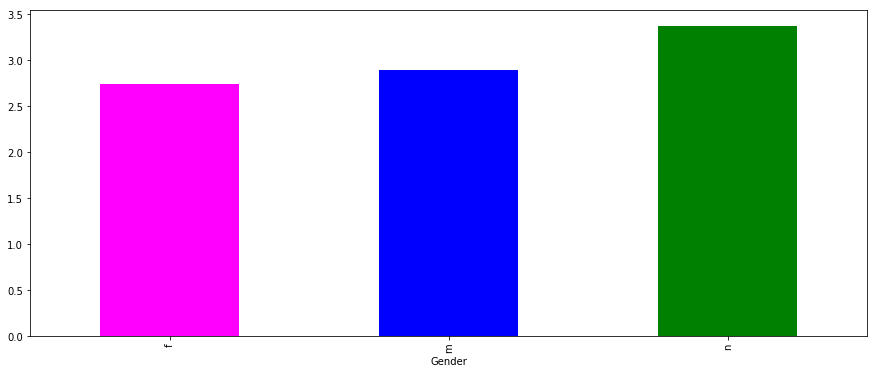

In [29]:
kband_by_gender = all_movies_df.groupby(['Gender'])['AVG_K_BAND'].describe()['mean']
kband_by_gender.plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

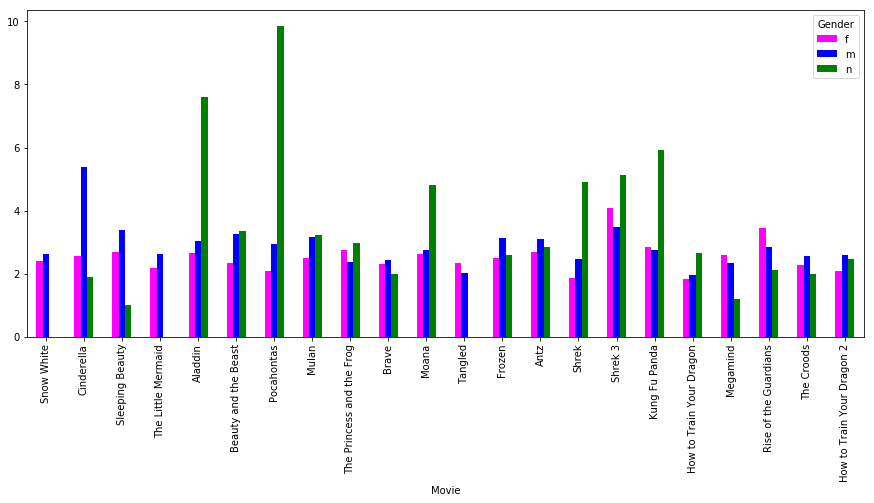

In [30]:
kband_by_gender = all_movies_df.groupby(['Movie','Gender'], sort=False)['AVG_K_BAND'].describe()['mean']
kband_by_gender.unstack().plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

In [31]:
all_movies_df.groupby(['Movie','Gender'], sort=False)['AVG_K_BAND'].describe()

count      mean        std       min  \
Movie                      Gender                                         
Snow White                 f         2.0  2.389351   0.079782  2.332937   
                           m        12.0  2.608765   0.425556  1.750000   
Cinderella                 f         8.0  2.570142   1.175377  1.000000   
                           m         9.0  5.385134   6.850950  1.200000   
                           n         5.0  1.890469   0.644833  1.000000   
Sleeping Beauty            f         7.0  2.678259   0.471002  2.193878   
                           m         8.0  3.396987   0.784383  2.160000   
                           n         1.0  1.000000        NaN  1.000000   
The Little Mermaid         f         8.0  2.171374   0.591781  1.100000   
                           m        15.0  2.620768   0.650783  1.476190   
                           n         0.0       NaN        NaN       NaN   
Aladdin                    f         2.0  2.645324   0.784431  2.090647   
                           m        22.0  3.030533   1.270001  1.000000   
                           n         3.0  7.591667  10.752916  1.000000   
Beauty and the Beast       f         8.0  2.335351   0.966800  1.250000   
                           m        17.0  3.259419   2.408554  1.785985   
                           n         2.0  3.357143   0.505076  3.000000   
Pocahontas                 f         3.0  2.069656   0.177005  1.957143   
                           m        13.0  2.943102   1.608432  1.817216   
                           n         1.0  9.857143        NaN  9.857143   
Mulan                      f         5.0  2.480843   0.232826  2.166667   
                           m        26.0  3.172512   2.188104  1.000000   
                           n         9.0  3.218724   4.813332  1.000000   
The Princess and the Frog  f         7.0  2.736976   1.686146  1.200000   
                           m        23.0  2.382266   0.842345  1.000000   
                           n         8.0  2.980979   1.780292  1.000000   
Brave                      f         3.0  2.299068   0.093320  2.217241   
                           m         8.0  2.418802   0.676929  1.636364   
                           n         1.0  2.000000        NaN  2.000000   
Moana                      f         5.0  2.608271   1.378328  1.583333   
...                                  ...       ...        ...       ...   
Frozen                     f        18.0  2.506559   1.271202  1.000000   
                           m        30.0  3.123374   1.821227  1.000000   
                           n        11.0  2.603463   2.480170  1.000000   
Antz                       f         7.0  2.676752   1.611610  1.387097   
                           m        13.0  3.102464   1.728259  1.727273   
                           n        35.0  2.842406   3.802172  1.000000   
Shrek                      f         3.0  1.871975   0.498932  1.333333   
                           m        28.0  2.453127   1.613305  1.000000   
                           n         4.0  4.910714   6.746416  1.166667   
Shrek 3                    f        18.0  4.073391   4.706302  1.000000   
                           m        32.0  3.490503   1.791008  1.000000   
                           n        12.0  5.137112   6.034490  1.000000   
Kung Fu Panda              f         6.0  2.829703   2.046156  1.000000   
                           m        16.0  2.746967   0.853723  1.750000   
                           n         8.0  5.905446   7.607052  1.454545   
How to Train Your Dragon   f         3.0  1.823071   0.424933  1.333333   
                           m        11.0  1.968213   0.630731  1.000000   
                           n        13.0  2.654116   1.677719  1.000000   
Megamind                   f         2.0  2.591549   0.577637  2.183099   
                           m         9.0  2.327557   0.699959  1.000000   
                           n         3.0  1.200000   0.34641

In [32]:
#What if you average this over number of speakers?
#What if we look exclusively at male and female protagonists?

In [33]:
all_movies_df.groupby(['Movie','Role','Gender'], sort=False)['AVG_K_BAND'].describe()

count      mean       std       min  \
Movie                      Role   Gender                                        
Snow White                 ANT    f         1.0  2.445765       NaN  2.445765   
                                  m         2.0  2.998331  0.070789  2.948276   
                           PRO    f         1.0  2.332937       NaN  2.332937   
                                  m         1.0  1.750000       NaN  1.750000   
                           HELPER m         9.0  2.617613  0.343759  2.000000   
Cinderella                 ANT    f         4.0  2.974348  1.393428  2.012739   
                                  m         0.0       NaN       NaN       NaN   
                           PRO    f         1.0  2.165971       NaN  2.165971   
                                  m         1.0  1.285714       NaN  1.285714   
                           HELPER f         1.0  2.249123       NaN  2.249123   
                                  m         3.0  2.719286  1.917708  1.200000   
                                  n         3.0  1.889520  0.190115  1.750000   
                           N      f         2.0  2.124324  1.590035  1.000000   
                                  m         5.0  7.804526  8.670873  2.208920   
                                  n         2.0  1.891892  1.261326  1.000000   
Sleeping Beauty            ANT    f         1.0  3.131818       NaN  3.131818   
                           PRO    f         1.0  2.290196       NaN  2.290196   
                                  m         1.0  2.160000       NaN  2.160000   
                           HELPER f         4.0  2.474307  0.286005  2.193878   
                           N      f         1.0  3.428571       NaN  3.428571   
                                  m         7.0  3.573699  0.652951  2.891720   
                                  n         1.0  1.000000       NaN  1.000000   
The Little Mermaid         ANT    f         2.0  2.137934  0.136142  2.041667   
                                  m         4.0  1.988653  0.425855  1.476190   
                           PRO    f         1.0  2.068132       NaN  2.068132   
                                  m         1.0  3.150895       NaN  3.150895   
                           HELPER m         4.0  2.710631  0.213230  2.469565   
                           N      f         5.0  2.205399  0.776887  1.100000   
                                  m         6.0  2.893915  0.760201  2.111111   
                                  n         0.0       NaN       NaN       NaN   
...                                         ...       ...       ...       ...   
How to Train Your Dragon   N      m         6.0  1.678898  0.531581  1.000000   
                                  n        11.0  2.773046  1.754011  1.000000   
Megamind                   ANT    m         1.0  2.389340       NaN  2.389340   
                           PRO    m         1.0  2.291416       NaN  2.291416   
                           HELPER m         1.0  2.158805       NaN  2.158805   
                           N      f         2.0  2.591549  0.577637  2.183099   
                                  m         6.0  2.351408  0.881195  1.000000   
                                  n         3.0  1.200000  0.346410  1.000000   
Rise of the Guardians      ANT    m         1.0  2.121860       NaN  2.121860   
                           PRO    m         1.0  2.172015       NaN  2.172015   
                           HELPER f         1.0  2.589062       NaN  2.589062   
                                  m         3.0  3.063118  0.922178  2.463500   
                           N      f         9.0  3.528474  1.636428  1.500000   
                                  m         7.0  2.960963  1.088033  2.000000   
                                  n         3.0  2.120198  1.202170  1.391304   
The Croods                 ANT    m         1.0  2.032948       NaN  2.032948   
                                  n         0.0       NaN       NaN      

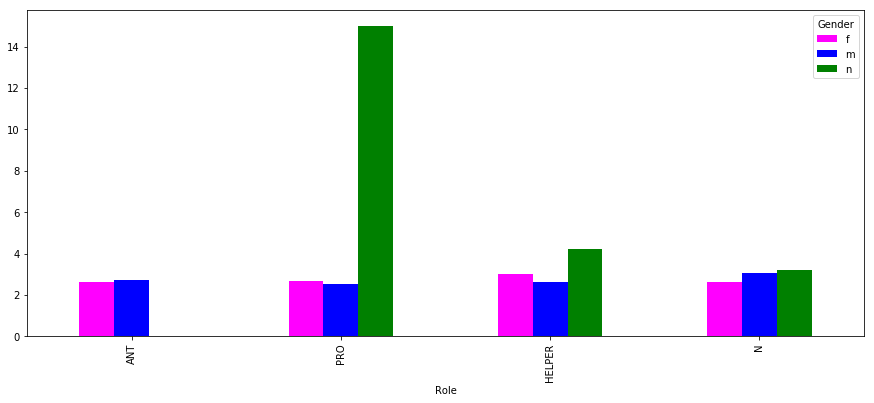

In [34]:
kband_by_movie_role_gender = all_movies_df.groupby(['Role','Gender'], sort=False)['AVG_K_BAND'].describe()['mean']
kband_by_movie_role_gender.unstack().plot.bar(color = ['magenta', 'blue', 'green'], figsize = (15,6))

So... female protagonists and female helpers average a higher k-band than male protagonists and male speakers...

In [35]:
all_movies_df[(all_movies_df.Role == 'PRO') & (all_movies_df.Gender == 'n')] #oh, donkey...always causing trouble...

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
428,DREAMWORKS,n,Shrek,PRO,shrek & fiona,NON-P,2.0,"[donkey, !]",2.0,"{donkey, !}",2001,1.0,1.414214,15.0


In [36]:
all_movies_df[(all_movies_df.Role == 'HELPER') & (all_movies_df.Gender == 'n')] #dup.genies should be male...

,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND
17,EARLY,n,Cinderella,HELPER,birds,NON-P,5.0,"[what, kind, of, dream, ?]",5.0,"{?, dream, what, of, kind}",1950,1.000000,2.236068,1.750000
20,EARLY,n,Cinderella,HELPER,mice,NON-P,106.0,"[he, !, zukzuk, ., hup, !, up, !, hup, ,, hup,...",48.0,"{you, come, no, your, not, keep, that, zukzuk,...",1950,0.452830,4.662172,2.106061
23,EARLY,n,Cinderella,HELPER,mouse,NON-P,29.0,"[breakfast, ., but, dress, old, ., very, nice,...",19.0,"{six, nice, four, okay, ,, old, two, very, but...",1950,0.655172,3.528211,1.812500
104,MID,n,Aladdin,HELPER,dup. genies,NON-P,18.0,"[duplicated, ,, duplicated, ,, duplicated, ,, ...",3.0,"{,, ., duplicated}",1992,0.166667,0.707107,20.000000
525,DREAMWORKS,n,Kung Fu Panda,HELPER,furious five,NON-P,9.0,"[what, ?, ?, good, morning, master, !, master, .]",7.0,"{master, ?, what, good, morning, ., !}",2008,0.777778,2.333333,1.600000
557,DREAMWORKS,n,How to Train Your Dragon,HELPER,tuffnut ruffnut,NON-P,20.0,"[i, 'm, on, it, !, i, 'm, on, it, !, i, 'm, on...",5.0,"{on, it, 'm, i, !}",2010,0.250000,1.118034,1.000000
558,DREAMWORKS,n,How to Train Your Dragon,HELPER,teens,NON-P,4.0,"[woohoo, !, yeah, !]",3.0,"{yeah, woohoo, !}",2010,0.750000,1.500000,3.000000
621,DREAMWORKS,n,How to Train Your Dragon 2,HELPER,tuffnut ruffnut,NON-P,13.0,"[it, 's, my, glory, !, no, sheep, ,, no, you, ...",12.0,"{you, my, ruining, no, ,, glory, always, 're, ...",2014,0.923077,3.328201,2.375000


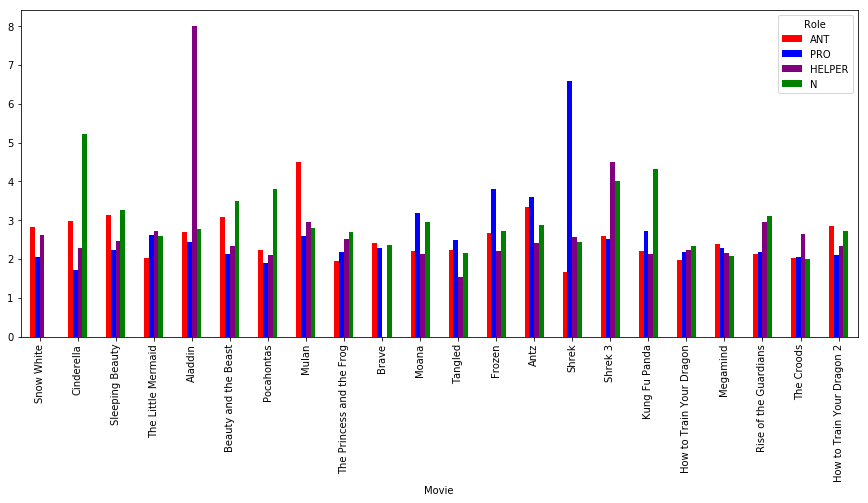

In [37]:
kband_by_movie_role = all_movies_df.groupby(['Movie','Role'], sort=False)['AVG_K_BAND'].describe()['mean']
kband_by_movie_role.unstack().plot.bar(color = ['red', 'blue', 'purple', 'green'], figsize = (15,6))

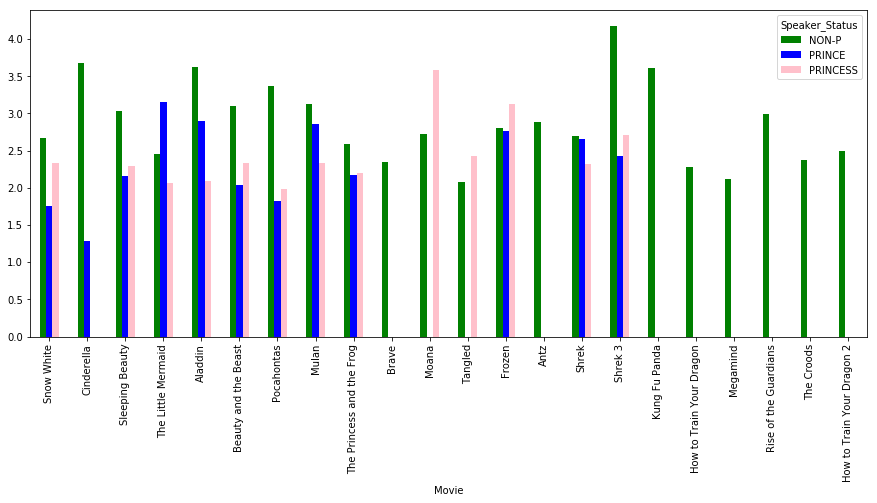

In [38]:
#what about according to royal status?
kband_by_movie_role = all_movies_df.groupby(['Movie','Speaker_Status'], sort=False)['AVG_K_BAND'].describe()['mean']
kband_by_movie_role.unstack().plot.bar(color = ['green', 'blue', 'pink'], figsize = (15,6))

In [55]:
#first a pie chart of basic gender distributions....
char_by_gen = all_movies_df.groupby('Gender')['Movie'].count()

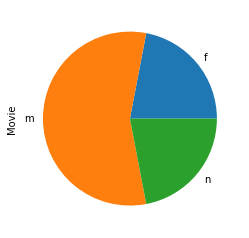

In [56]:
char_by_gen.plot.pie() #mostly male speakers....

In [57]:
char_by_gen_disney = all_movies_df[all_movies_df.Disney_Period != "DREAMWORKS"].groupby('Gender')['Movie'].count()
char_by_gen_dreamworks = all_movies_df[all_movies_df.Disney_Period == "DREAMWORKS"].groupby('Gender')['Movie'].count()

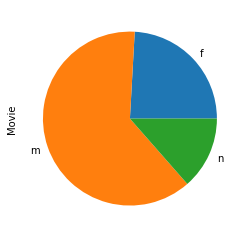

In [58]:
char_by_gen_disney.plot.pie() #in both production companies, more male characters...

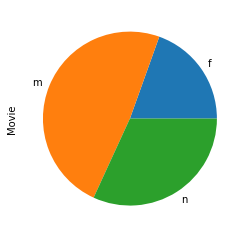

In [59]:
char_by_gen_dreamworks.plot.pie()

In [65]:
%pprint

Pretty printing has been turned OFF


# Number of Exclamations & Questions
How often do female characters ask questions? How often do they shout? Does shouting indicate any kind of confidence or authority?

In [67]:
all_movies_df['Exclamation_Count'] = all_movies_df['Total_Toks'].map(lambda x: x.count('!'))

In [68]:
all_movies_df['Question_Count'] = all_movies_df['Total_Toks'].map(lambda x: x.count('?'))

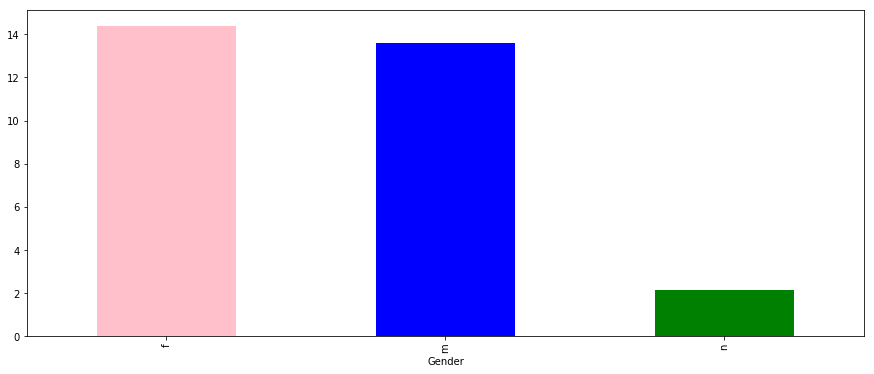

In [70]:
exclam_by_gen = all_movies_df.groupby(['Gender'])['Exclamation_Count'].describe()['mean']
exclam_by_gen.plot.bar(color = ['pink', 'blue', 'green'], figsize = (15,6))
#slightly more exclamations by female characters

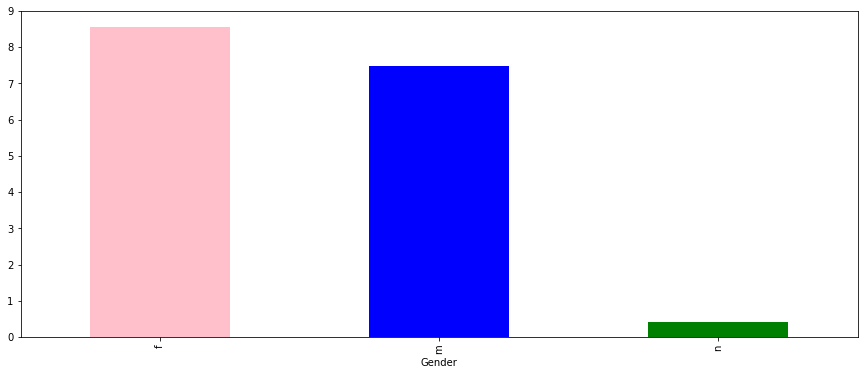

In [71]:
question_by_gen = all_movies_df.groupby(['Gender'])['Question_Count'].describe()['mean']
question_by_gen.plot.bar(color = ['pink', 'blue', 'green'], figsize = (15,6))
#And more questions too...

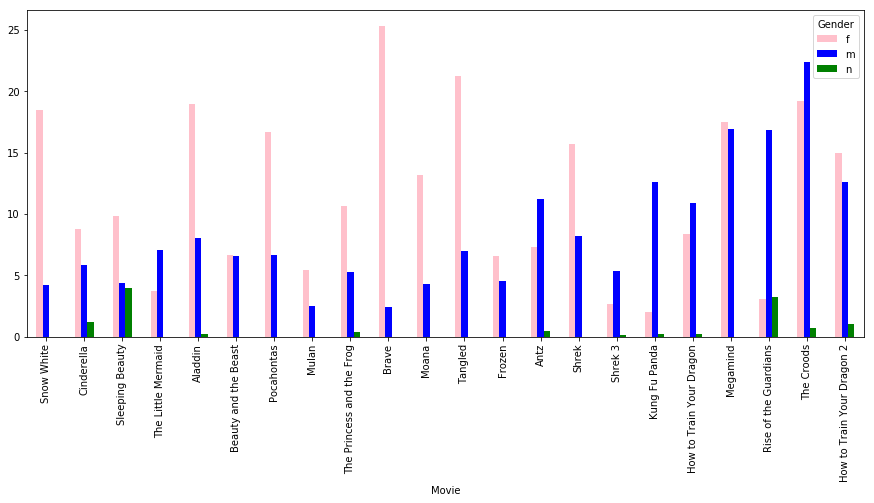

In [74]:
#across all movies
question_by_gen = all_movies_df.groupby(['Movie','Gender'], sort=False)['Question_Count'].describe()['mean']
question_by_gen.unstack().plot.bar(color = ['pink', 'blue', 'green'], figsize = (15,6))

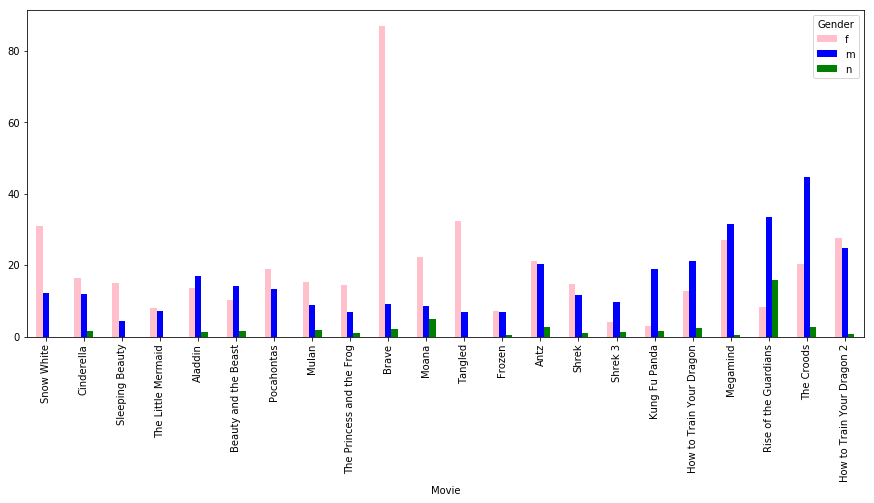

In [75]:
exclam_by_gen = all_movies_df.groupby(['Movie','Gender'], sort=False)['Exclamation_Count'].describe()['mean']
exclam_by_gen.unstack().plot.bar(color = ['pink', 'blue', 'green'], figsize = (15,6))

In [76]:
#should divide by number of male/female characters in each movie


,Disney_Period,Gender,Movie,Role,Speaker,Speaker_Status,Total_Tok_Count,Total_Toks,Total_Type_Count,Total_Types,Year,TTR,G_TTR,AVG_K_BAND,Exclamation_Count,Question_Count
0,EARLY,f,Snow White,ANT,queen,NON-P,940.0,"[slave, in, the, magic, mirror, come, from, th...",314.0,"{fall, to, look, wo, kiss, 'd, queenly, so, so...",1937,0.334043,10.241551,2.445765,42,10
1,EARLY,m,Snow White,ANT,mirror,NON-P,81.0,"[what, wouldst, thou, know, ,, my, queen, ?, f...",57.0,"{you, more, your, than, her, grace, not, lovel...",1937,0.703704,6.333333,3.048387,0,1
2,EARLY,m,Snow White,PRO,prince,PRINCE,5.0,"[today, hello, ., one, song]",5.0,"{hello, song, one, today, .}",1937,1.000000,2.236068,1.750000,0,0
3,EARLY,f,Snow White,PRO,snow white,PRINCESS,1231.0,"[oh, !, oh, ., hello, there, ., what, 's, the,...",311.0,"{mama, to, tidy, wo, look, 'd, eat, so, than, ...",1937,0.252640,8.864033,2.332937,20,27
4,EARLY,m,Snow White,ANT,guard,NON-P,95.0,"[yes, ,, your, majesty, ., but, ,, your, majes...",43.0,"{you, come, your, back, never, little, run, of...",1937,0.452632,4.411707,2.948276,18,0
